### The purpose of nba-api is to scrape basketball-reference.com and extract matchup information and team statistics
Jake Giguere giguere@bu.edu

disclaimer: This is software is soley for educational purposes. Please do not use this for gambling or sport-betting.

In [1]:
import os
import time
from io import StringIO

import pandas as pd
import requests
import tensorflow as tf
from bs4 import BeautifulSoup

print("TensorFlow version:", tf.__version__)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/jakegiguere/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2024-12-24 13:42:04.803158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2


Start by extracting the matchups for every year from 2022-2024 in months Oct-Apr and concatenate them to a dataframe. We need the Home team, Pts, Visitor Team, Pts
url: https://www.basketball-reference.com/leagues/NBA_2024_games-{month}.html#schedule 

In [ ]:
months = ["october", "november", "december", "january", "february", "march", "april"]
data = pd.DataFrame()
for year in range(2022,2025):
    for month in months:
        url = f"https://www.basketball-reference.com/leagues/NBA_{year}_games-{month}.html#schedule"

        try:
            r = requests.get(url)
            r.raise_for_status()
        except Exception as e:
            print("Could not fetch months {} games")
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table', {'id': 'schedule'})

        if table:
            table = StringIO(str(table))
            month_data = pd.read_html(table)[0]
            data = pd.concat([data, month_data], ignore_index=True) 






### Convert data into a CSV so we can prevent repetitive api calls

In [ ]:
data.to_csv('Data/matchups.csv')
data.shape

### 3833 games collected with 12 rows however we only need the 4 rows mentioned above.

In [ ]:
features = ['Visitor/Neutral', 'PTS', 'Home/Neutral', 'PTS.1']

data = data[features]
data.head()

### Now lets collect team statistics using game log. We should also grab all the team abreviations using ChatGPT to save time
url: https://www.basketball-reference.com/teams/{team_abrv}/{year}/gamelog/


In [293]:
# Dictionary mapping team names to their abbreviations
TEAM_MAP = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# Reverse dictionary for abbreviation to full team name
ABBR_MAP = {abbr: team for team, abbr in TEAM_MAP.items()}

def get_team_name_or_abbr(input_str):
    """Convert a team name to its abbreviation or vice versa."""
    input_str = input_str.strip()
    
    # Check if the input is an abbreviation
    if input_str.upper() in ABBR_MAP:
        return ABBR_MAP[input_str.upper()]
    # Check if the input is a full team name
    elif input_str in TEAM_MAP:
        return TEAM_MAP[input_str]
    else:
        return "Team not found."

# Example Usage
print(get_team_name_or_abbr("Boston Celtics"))   # Output: "BOS"
print(get_team_name_or_abbr("LAL"))              # Output: "Los Angeles Lakers"
print(get_team_name_or_abbr("NYK"))              # Output: "New York Knicks"
print(get_team_name_or_abbr("Philadelphia 76ers"))  # Output: "PHI"
print(get_team_name_or_abbr("ATL"))              # Output: "Atlanta Hawks"


BOS
Los Angeles Lakers
New York Knicks
PHI
Atlanta Hawks


In [ ]:
abv = list(TEAM_MAP.values())
abv

### Retreive Data from 2022-2024

In [373]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
abreviations = list(TEAM_MAP.values()) #list of all abreviations
years = range(2023, 2026)
teams_data = pd.DataFrame()
for year in years:
    for abrv in abreviations:
        url = f'https://www.basketball-reference.com/teams/{abrv}/{year}/gamelog/'

        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()
        except Exception as e:
            print(f'Could not fetch {abrv}/{year}')
            r.raise_for_status()
        
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table', {'id': 'tgl_basic'})


        if table:
            table = StringIO(str(table))
            team = pd.read_html(table)[0]
            team['tm'] = abrv
            teams_data = pd.concat([teams_data, team], ignore_index=True)

    time.sleep(120)




In [374]:
teams_data.shape

(6428, 42)

### Save/Overwrite to gamelog csv file should have 2700x3 years about +8000 rows 

In [375]:
teams_data.to_csv('Data/gamelogs2022_2024.csv', mode='w+', header=not pd.io.common.file_exists('Data/gamelogs2022_2024.csv'), index=False)

Clean up the game log. repeated headers, etc. save to Data/cleaned_gamelogs.csv


In [377]:
data = pd.read_csv('Data/gamelogs2022_2024.csv', header=0)

#Remove any multi labeled rows, and unnamed values 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data[data['Rk'].apply(lambda x: str(x).isdigit())]

data.reset_index(drop=True, inplace=True)
# Display the first few rows of the cleaned DataFrame
data.to_csv('Data/cleaned_gamelogs.csv', index=False)


### Prepare the data for the Sequential Model

In [378]:
cleaned_df = pd.read_csv('Data/cleaned_gamelogs.csv')
print(cleaned_df.columns)

# Load the cleaned dataset
data = pd.read_csv('Data/cleaned_gamelogs.csv')
feature_columns = ['PTS.1', 
                # 'Home/Away', 'Home/Away.1',
                'FG%', 'FG%.1',
                'FGA', 'FGA.1',
                '3P%', '3P%.1',
                '3PA', '3PA.1',
                'ORB', 'ORB.1',
                'TRB', 'TRB.1',
                'AST', 'AST.1',
                'TOV', 'TOV.1',
                'STL', 'STL.1',
                'PF', 'PF.1']
# Define features (excluding 'Tm' which is the target)
# data['Home/Away'] = data['Home/Away'].fillna('').astype(str)
# 
# data['Home/Away'] = data['Home/Away'].apply(lambda x: 1 if '@' in x else 0)
# Add Home/Away.1 column
# data['Home/Away.1'] = (data['Home/Away'] == 0).astype(int)

data.to_csv('Data/cleaned_gamelogs.csv', index=False)

features = data[feature_columns]
target = data['PTS']

# Split the data into training and testing sets (80% train, 20% test)
X_train, _, y_train, _ = train_test_split(features, target)

# Scale the features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


print(X_train.shape)
# print(X_test.shape)

print(X_train[1:5])



Index(['Rk', 'G', 'Date', 'Opp', 'W/L', 'PTS', 'PTS.1', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1',
       'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1',
       'TOV.1', 'PF.1', 'ATL'],
      dtype='object')
(4416, 21)
[[ 0.61963681  0.13226937  1.93690341 -1.05228114 -1.04381777  1.39826485
   0.63310632 -1.46851802  0.84534334  0.11893021 -1.16514603 -0.67962031
  -1.42362739 -0.59041497 -0.6020709  -0.51069785 -0.52161701 -0.19645828
   0.15645262 -0.56102082  0.88745265]
 [-0.98246873  0.26038991 -0.72103231 -0.91357678 -0.49457746  0.19215646
  -0.54709329 -0.88819402  0.41096631 -1.68852827 -0.65302451 -1.13129132
  -0.23703052 -0.59041497 -0.21024346 -1.26749038  0.24825622  0.14726588
  -1.2218911  -0.3226423   0.40455069]
 [-1.30288984  0.91929553  0.36047257 -0.63616805 -0.76919762  0.96836483
  -3.12207425 -1.17835602 -0.74

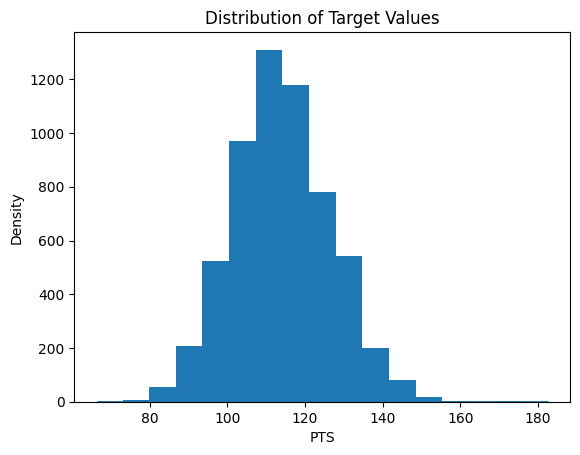

Target Value Stats:
count    5876.000000
mean      114.213410
std        12.452315
min        73.000000
25%       106.000000
50%       114.000000
75%       123.000000
max       176.000000
Name: PTS, dtype: float64


In [345]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(target, fill=True,)
plt.hist(target, bins=15)
plt.title("Distribution of Target Values")
plt.show()

print("Target Value Stats:")
print(target.describe())


### Check for NaNs or Infinite Values

In [50]:
import numpy as np

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from keras import layers, callbacks


In [379]:

model = Sequential(
    [
    layers.Input(shape=(21,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    
    layers.Dense(16, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(1)  # Output layer for regression
    ]
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, shuffle=True, callbacks=[lr_scheduler, early_stopping])


Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9680.7764 - mae: 92.3808 - val_loss: 556.8242 - val_mae: 18.4608 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 456.9000 - mae: 17.2512 - val_loss: 347.9789 - val_mae: 14.7840 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 305.2034 - mae: 14.0877 - val_loss: 248.2439 - val_mae: 12.7345 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 207.1869 - mae: 11.5290 - val_loss: 165.0722 - val_mae: 10.1797 - learning_rate: 0.0010
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147.6321 - mae: 9.6795 - val_loss: 113.7737 - val_mae: 8.5126 - learning_rate: 0.0010
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99.8365 - mae: 7.9676 - val_loss: 80.6309 - val_mae: 7.1325 - learning_rate: 0.0010
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.0353 - mae: 6.4694 - val_loss: 58.1040 - val_ma

In [380]:
# Save the trained model right after training
model.save('nba_model.keras')
print("Model saved as 'nba_model.h5'")

Model saved as 'nba_model.h5'


### Evaluate model

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
import matplotlib.pyplot as plt

# Assuming `y_test` is the actual values and `predictions` are your model's predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Game Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Scores')
plt.legend()
plt.show()

In [382]:
# Step 1: Scrape today's games
from datetime import datetime

def get_today_games():
    # Define the URL for the November 2024 NBA schedule
    url = "https://www.basketball-reference.com/leagues/NBA_2025_games-january.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the schedule table
    schedule_table = soup.find('table', {'id': 'schedule'})
    if not schedule_table:
        print("Schedule table not found.")
        return pd.DataFrame()
    
    # Extract rows from the table
    rows = schedule_table.find_all('tr')
    
    # Get today's date in the format used on the website
    today = datetime.now().strftime('%a, %b %d-, %Y')
    print(today)
    tmrw = "Wed, Dec 25, 2024"
    # Initialize a list to hold today's games
    games_today = []
    
    for row in rows:
        # Extract the date cell
        date_cell = row.find('th', {'data-stat': 'date_game'})
        if date_cell and date_cell.text.strip() == today:
            # Extract team names
            away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
            home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
            games_today.append({'home_team': home_team, 'away_team': away_team})
    
    # Convert the list to a DataFrame
    return pd.DataFrame(games_today)

# Fetch today's games
today_games = get_today_games()
print("Today's Matchups:")


print(today_games)


Wed, Jan 01, 2025
Today's Matchups:
Empty DataFrame
Columns: []
Index: []


Get team current team per game data

In [351]:
def get_team_per_game_stats(team_abbr):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://www.basketball-reference.com/teams/{team_abbr}/2025.html"
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    per_game_table = soup.find('table', {'id': 'per_game_stats'})
    if not per_game_table:
        print(f"Per-game table not found for {team_abbr}.")
        return {}
    if per_game_table:
        table = StringIO(str(per_game_table))
        df = pd.read_html(table)[0]
        
        # Read the table using pandas
    
    
        # Extract the row corresponding to 'Team Totals'
        team_totals_row = df[df['Player'] == 'Team Totals']
        if team_totals_row.empty:
            print(f"No 'Team Totals' row found for {team_abbr}.")
            return {}

        # Convert the row to a dictionary
        team_stats = team_totals_row.iloc[0].to_dict()

        # Extract only the required columns
        feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 
                           'AST', 'TOV', 'STL', 'PF']
    
        # Map to desired format
        relevant_stats = {col: team_stats.get(col, 0) for col in feature_columns}

        return relevant_stats
    
        
    
home = get_team_name_or_abbr(today_games.iloc[0][0])
away = get_team_name_or_abbr(today_games.iloc[0][1])

home_teams = today_games['home_team']
away_teams = today_games['away_team']

home = get_team_per_game_stats(home)
away = get_team_per_game_stats(away)

print(today_games)



/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_1569/311355562.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  home = get_team_name_or_abbr(today_games.iloc[0][0])
/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_1569/311355562.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  away = get_team_name_or_abbr(today_games.iloc[0][1])


               home_team               away_team
0         Boston Celtics         Toronto Raptors
1         Indiana Pacers         Milwaukee Bucks
2      San Antonio Spurs    Los Angeles Clippers
3  Oklahoma City Thunder  Minnesota Timberwolves
4     Los Angeles Lakers     Cleveland Cavaliers
5           Phoenix Suns       Memphis Grizzlies


### Create a match up vector for both teams to follow the model features

In [352]:
def create_matchup_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    home_stats = get_team_per_game_stats(home_abbr)
    away_stats = get_team_per_game_stats(away_abbr)
    
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

### Get Data for todays games home teams

In [353]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
home_feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(home_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
home_feature_df = home_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
   PTS.1    FG%  FG%.1  FGA  FGA.1    3P%  3P%.1  3PA  3PA.1  ORB  ...  TRB  \
0   10.4  0.458  0.463  8.8    8.4  0.364  0.343  4.9    3.1  1.1  ...  4.4   
1   10.1  0.488  0.478  8.2    7.7  0.373  0.389  3.2    3.4  0.8  ...  3.8   
2   10.3  0.456  0.468  7.8    8.0  0.348  0.371  3.5    3.2  1.0  ...  4.0   
3   10.7  0.466  0.458  8.1    8.5  0.345  0.372  3.4    3.9  0.9  ...  3.9   
4   11.1  0.474  0.504  8.5    8.1  0.353  0.408  3.3    3.6  0.9  ...  4.1   
5   10.8  0.468  0.484  8.2    8.2  0.378  0.369  3.7    3.4  0.9  ...  4.1   

   TRB.1  AST  AST.1  TOV  TOV.1  STL  STL.1   PF  PF.1  
0    4.2  2.5    2.7  1.1    1.5  0.7    0.7  1.6   2.1  
1    3.9  2.6    2.2  1.3    1.2  0.7    0.7  1.

In [354]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['away_team'],game['home_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
away_feature_df = pd.DataFrame(feature_vectors)



# print("Feature Vectors for Today's Matchups:")
# print(away_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
away_feature_df = away_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(away_feature_df)
print("Shape of feature_df:", away_feature_df.shape)

Adjusted Feature Vectors:
   PTS.1    FG%  FG%.1  FGA  FGA.1    3P%  3P%.1  3PA  3PA.1  ORB  ...  TRB  \
0   11.5  0.463  0.458  8.4    8.8  0.343  0.364  3.1    4.9  1.2  ...  4.2   
1   10.7  0.478  0.488  7.7    8.2  0.389  0.373  3.4    3.2  0.7  ...  3.9   
2   10.0  0.468  0.456  8.0    7.8  0.371  0.348  3.2    3.5  1.0  ...  4.1   
3   10.1  0.458  0.466  8.5    8.1  0.372  0.345  3.9    3.4  1.0  ...  4.2   
4   11.2  0.504  0.474  8.1    8.5  0.408  0.353  3.6    3.3  0.9  ...  4.0   
5   10.7  0.484  0.468  8.2    8.2  0.369  0.378  3.4    3.7  1.1  ...  4.2   

   TRB.1  AST  AST.1  TOV  TOV.1  STL  STL.1   PF  PF.1  
0    4.4  2.7    2.5  1.5    1.1  0.7    0.7  2.1   1.6  
1    3.8  2.2    2.6  1.2    1.3  0.7    0.7  1.7   1.8  
2    4.0  2.3    2.5  1.5    1.3  0.9    0.7  1.8   1.5  
3    3.9  2.5    2.2  1.5    1.0  0.8    1.0  1.8   1.8  
4    4.1  2.6    2.6  1.1    1.3  0.8    0.8  1.7   1.6  
5    4.1  2.7    2.6  1.4    1.3  0.8    0.8  1.9   1.7  

[6 rows x 21 

### Load out model 'nba_model.keras' and predict Home team scores

In [355]:
loaded_model = tf.keras.models.load_model('nba_model.keras')
# loaded_model = model
# Example: Make predictions using the loaded model

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_feature_df)
away_scaled_features = scaler.fit_transform(away_feature_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame
today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Predicted Scores for Today's Matchups:
               home_team               away_team  home_predicted_scores  \
0         Boston Celtics         Toronto Raptors             133.733170   
1         Indiana Pacers         Milwaukee Bucks             113.461655   
2      San Antonio Spurs    Los Angeles Clippers              94.632004   
3  Oklahoma City Thunder  Minnesota Timberwolves             117.479790   
4     Los Angeles Lakers     Cleveland Cavaliers             115.519547   
5           Phoenix Suns       Memphis Grizzlies             119.117950   

   away_predicted_scores  
0             106.200233  
1             117.675476  
2             100.536270  
3             117.523018  
4             142.281311  
5             119.651382  


12.34408478947367


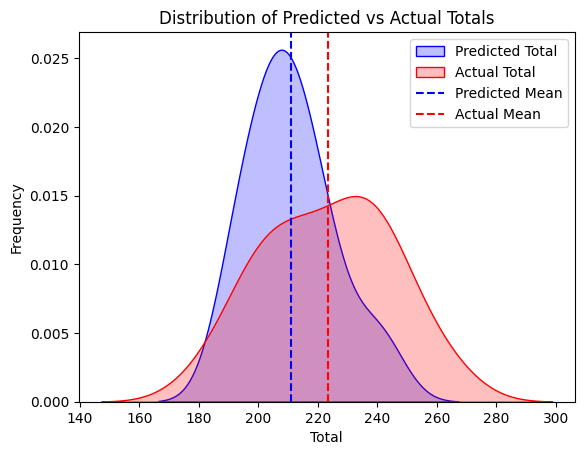

In [371]:
import seaborn as sns
xlsx = pd.read_excel('data/nba.xlsx', sheet_name='Raw')
# print(xlsx.head())
xlsx.columns = xlsx.columns.str.strip()
team_name = 'SAS'
cle = xlsx[(xlsx['home'] == team_name) | (xlsx["away"] == team_name)]
# print(cle)
sns.kdeplot(cle['pred total'], color='blue', label='Predicted Total', fill=True)
sns.kdeplot(cle['Total Actual'], color='red', label='Actual Total', fill=True)

plt.axvline(cle['pred total'].mean(), color='blue', linestyle='--', label='Predicted Mean')
plt.axvline(cle['Total Actual'].mean(), color='red', linestyle='--', label='Actual Mean')
print(cle['Total Actual'].mean() - cle['pred total'].mean())
plt.title('Distribution of Predicted vs Actual Totals')
plt.xlabel('Total')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
cle['error'] = cle['pred total'] - cle['Actual']
sns.kdeplot(cle['error'], shade=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


### H2H Data


In [289]:
def get_h2h_stats(teamA, teamB):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://stathead.com/basketball/versus-finder.cgi?request=1&match=versus_teamvteam&seasons_type=forall&year_min=2024&year_max=2025&team_id1={teamA}&team_id2={teamB}"
    
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    h2h_table = soup.find('table', {'id': 'stats_h2h_per_game_rs'})
    if not h2h_table:
        #TODO get overall per game table
        print(f"Per-game table not found for {teamA} vs. {teamB}.")
        return {}
    if h2h_table:
        table = StringIO(str(h2h_table))
        df = pd.read_html(table)[0]
        

        feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL', 'PF']
        relevant_stats = {col: df.get(col, 0) for col in feature_columns}
        
        return relevant_stats


In [290]:
def create_h2h_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    h2h_stats = pd.DataFrame(get_h2h_stats(home_abbr, away_abbr))
    home_stats = h2h_stats.iloc[0]
    away_stats = h2h_stats.iloc[1]                
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

In [291]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_h2h_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(feature_df.columns)


# Filter the DataFrame to include only the columns your model expects


# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
   PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0  107.1  0.455  0.473  83.6   80.5  0.331  0.364  33.2   31.6   9.8  ...   
1  117.4  0.488  0.467  95.3   95.7  0.409  0.342  42.3   38.9  14.7  ...   
2  121.6  0.480  0.484  94.6   91.7  0.354  0.370  32.7   33.6  13.1  ...   
3  111.8  0.421  0.464  89.0   84.0  0.297  0.357  37.0   39.3  13.0  ...   
4  114.3  0.424  0.464  87.6   91.7  0.328  0.369  41.4   38.7  10.0  ...   
5  110.2  0.483  0.463  89.4   91.4  0.384  0.351  33.3   37.0   9.9  ...   

    TRB  TRB.1   AST  AST.1   TOV  TOV.1  STL  STL.1    PF  PF.1  
0  40.4   41.6  21.9   24.1  16.1   16.1  8.4    8.7  22.0  21.2  
1  51.6   42.3  27.0   28.3  14.7   12.2  7.

In [292]:
loaded_model = tf.keras.models.load_model('nba_model.keras')

# loaded_model = model
# Example: Make predictions using the loaded model
print(feature_df.columns)

home_vect_df = feature_df.drop(['PTS'], axis=1)
away_vect_df = feature_df.drop(['PTS.1'], axis=1)

# home_vect = vect_df.drop(['PTS'], axis=1)
# away_vect = vect_df.drop(['PTS.1'], axis=1)

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_vect_df)
away_scaled_features = scaler.fit_transform(away_vect_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame


today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Predicted Scores for Today's Matchups:
                home_team          away_team  home_predicted_scores  \
0           Orlando Magic      Brooklyn Nets             114.819077   
1          Boston Celtics     Indiana Pacers             119.169876   
2         Toronto Raptors      Atlanta Hawks             142.273758   
3         Houston Rockets         Miami Heat             116.004677   
4   Oklahoma City Thunder  Memphis Grizzlies             105.903557   
5  Minnesota Timberwolves  San Antonio Spurs              98.664680   

   away_predicted_scores  teamA_predicted_scores  teamB_predicted_scores  
0             120.055534              112.055656              115.632149  
1             127.